In [2]:
import os, gymnasium as gym, highway_env      
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import SubprocVecEnv
import os, time, pickle, psutil, highway_env, gymnasium as gym
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import SubprocVecEnv
from stable_baselines3.common.callbacks import EvalCallback
import matplotlib.pyplot as plt


2025-04-24 17:29:51.426565: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-24 17:29:51.474081: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-24 17:29:54.546065: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [3]:
# chemins projet
ROOT      = os.path.abspath("..")          # /project/task3
CONFIG_FN = os.path.join(ROOT, "configs", "config3.pkl")
LOG_DIR   = os.path.join(ROOT, "logs", "ppo_main")
MODEL_DIR = os.path.join(ROOT, "models")
os.makedirs(LOG_DIR, exist_ok=True); os.makedirs(MODEL_DIR, exist_ok=True)

# charger la config Highway
with open(CONFIG_FN, "rb") as f: cfg = pickle.load(f)

# nb de processus
CORES   = psutil.cpu_count(logical=False)        # 24
N_ENVS  = min(22, CORES - 2)                     # 22 envs
print(f"{N_ENVS=}")


N_ENVS=22


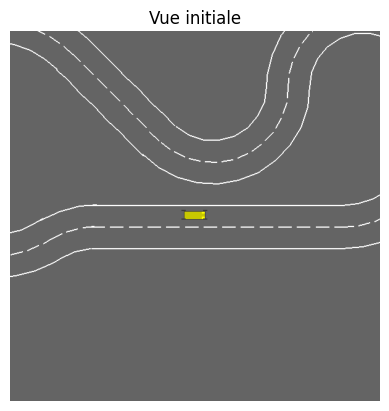

In [4]:
env_vis = gym.make("racetrack-v0", render_mode="rgb_array")
env_vis.unwrapped.configure(cfg)
obs, _ = env_vis.reset()
frame = env_vis.render()


plt.imshow(frame)
plt.axis("off")
plt.title("Vue initiale")
plt.show()

env_vis.close()


In [5]:
vec_env = make_vec_env(
    "racetrack-v0",
    n_envs=N_ENVS,
    env_kwargs={"config": cfg},
    vec_env_cls=SubprocVecEnv,
    vec_env_kwargs={"start_method": "fork"},   # <- important
)



In [6]:
N_STEPS    = 512                         # par env
BATCH_SIZE = 1024                        # doit diviser N_ENVS*N_STEPS (=11264)
TOTAL_TS   = 100_000                     # par env  
LR         = 5e-4                        # learning-rate du repo d’origine
GAMMA      = 0.90                        # idem
N_EPOCHS   = 10                          # PPO update epochs

policy_kwargs = dict(net_arch=[dict(pi=[256, 256],
                                    vf=[256, 256])])

model = PPO(
    "MlpPolicy",
    vec_env,
    policy_kwargs=policy_kwargs,
    n_steps=N_STEPS,
    batch_size=BATCH_SIZE,
    n_epochs=N_EPOCHS,
    learning_rate=LR,
    gamma=GAMMA,
    verbose=1,
    tensorboard_log=LOG_DIR,
)


Using cpu device


/usr/users/streamingjailbreakdetection/elbarichi_moh/miniconda3/lib/python3.12/site-packages/stable_baselines3/common/policies.py:486: UserWarning: As shared layers in the mlp_extractor are removed since SB3 v1.8.0, you should now pass directly a dictionary and not a list (net_arch=dict(pi=..., vf=...) instead of net_arch=[dict(pi=..., vf=...)])
  warnings.warn(


In [7]:
eval_env = gym.make("racetrack-v0")
eval_env.unwrapped.configure(cfg)
eval_cb = EvalCallback(
    eval_env,
    eval_freq=20_000,        # toutes les 20 k pas globaux
    n_eval_episodes=5,
    log_path=LOG_DIR,
    deterministic=True,
)


In [10]:
start = time.time()
model.learn(total_timesteps=TOTAL_TS,
            tb_log_name="main_run",
            callback=eval_cb,
            progress_bar=True)
print("⏱  Durée entraînement :", (time.time()-start)/60, "min")

model_path = os.path.join(MODEL_DIR, "ppo_racetrack_fast.zip")
model.save(model_path)
with open(model_path.replace(".zip", "_info.txt"), "w") as f:
    f.write(f"algo=PPO\nn_envs={N_ENVS}\n"
            f"n_steps={N_STEPS}\nbatch_size={BATCH_SIZE}\n"
            f"lr={LR}\ngamma={GAMMA}\n"
            f"total_ts/env={TOTAL_TS}\n")
print("✓ modèle & méta sauvegardés →", model_path)


Logging to /usr/users/streamingjailbreakdetection/elbarichi_moh/Reinforcement-Learning-Project/task3/logs/ppo_main/main_run_4


Output()

/usr/users/streamingjailbreakdetection/elbarichi_moh/miniconda3/lib/python3.12/site-packages/stable_baselines3/common/callbacks.py:418: UserWarning: Training and eval env are not of the same type<stable_baselines3.common.vec_env.subproc_vec_env.SubprocVecEnv object at 0x7f7c2e2b5040> != <stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv object at 0x7f7dea0639e0>
  warnings.warn("Training and eval env are not of the same type" f"{self.training_env} != {self.eval_env}")


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 169      |
|    ep_rew_mean     | 14.3     |
| time/              |          |
|    fps             | 385      |
|    iterations      | 1        |
|    time_elapsed    | 29       |
|    total_timesteps | 11264    |
---------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 336         |
|    ep_rew_mean          | 15.7        |
| time/                   |             |
|    fps                  | 385         |
|    iterations           | 2           |
|    time_elapsed         | 58          |
|    total_timesteps      | 22528       |
| train/                  |             |
|    approx_kl            | 0.003277302 |
|    clip_fraction        | 0.0191      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.4        |
|    explained_variance   | -0.35       |
|    learning_rate        | 0.0005      |
|    loss                 | 0.024       |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.00868    |
|    std                  | 0.96        |
|    value_loss           | 0.103       |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.14e+03     |
|    ep_rew_mean          | 24.3         |
| time/                   |              |
|    fps                  | 377          |
|    iterations           | 3            |
|    time_elapsed         | 89           |
|    total_timesteps      | 33792        |
| train/                  |              |
|    approx_kl            | 0.0031112703 |
|    clip_fraction        | 0.0169       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.36        |
|    explained_variance   | 0.795        |
|    learning_rate        | 0.0005       |
|    loss                 | -0.00643     |
|    n_updates            | 20           |
|    policy_gradient_loss | -0.0113      |
|    std                  | 0.923        |
|    value_loss           | 0.0328       |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 881         |
|    ep_rew_mean          | 32.3        |
| time/                   |             |
|    fps                  | 376         |
|    iterations           | 4           |
|    time_elapsed         | 119         |
|    total_timesteps      | 45056       |
| train/                  |             |
|    approx_kl            | 0.004825986 |
|    clip_fraction        | 0.028       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.32       |
|    explained_variance   | 0.813       |
|    learning_rate        | 0.0005      |
|    loss                 | 0.0251      |
|    n_updates            | 30          |
|    policy_gradient_loss | -0.0114     |
|    std                  | 0.881       |
|    value_loss           | 0.114       |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 843         |
|    ep_rew_mean          | 38.6        |
| time/                   |             |
|    fps                  | 376         |
|    iterations           | 5           |
|    time_elapsed         | 149         |
|    total_timesteps      | 56320       |
| train/                  |             |
|    approx_kl            | 0.008741685 |
|    clip_fraction        | 0.0644      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.26       |
|    explained_variance   | 0.88        |
|    learning_rate        | 0.0005      |
|    loss                 | 0.165       |
|    n_updates            | 40          |
|    policy_gradient_loss | -0.0175     |
|    std                  | 0.831       |
|    value_loss           | 0.412       |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 833         |
|    ep_rew_mean          | 59.5        |
| time/                   |             |
|    fps                  | 375         |
|    iterations           | 6           |
|    time_elapsed         | 179         |
|    total_timesteps      | 67584       |
| train/                  |             |
|    approx_kl            | 0.005038553 |
|    clip_fraction        | 0.031       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.21       |
|    explained_variance   | 0.942       |
|    learning_rate        | 0.0005      |
|    loss                 | 0.0279      |
|    n_updates            | 50          |
|    policy_gradient_loss | -0.0127     |
|    std                  | 0.791       |
|    value_loss           | 0.126       |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 466         |
|    ep_rew_mean          | 108         |
| time/                   |             |
|    fps                  | 372         |
|    iterations           | 8           |
|    time_elapsed         | 241         |
|    total_timesteps      | 90112       |
| train/                  |             |
|    approx_kl            | 0.011050271 |
|    clip_fraction        | 0.109       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.12       |
|    explained_variance   | 0.934       |
|    learning_rate        | 0.0005      |
|    loss                 | 0.248       |
|    n_updates            | 70          |
|    policy_gradient_loss | -0.0168     |
|    std                  | 0.73        |
|    value_loss           | 0.572       |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 381         |
|    ep_rew_mean          | 137         |
| time/                   |             |
|    fps                  | 371         |
|    iterations           | 9           |
|    time_elapsed         | 272         |
|    total_timesteps      | 101376      |
| train/                  |             |
|    approx_kl            | 0.011834297 |
|    clip_fraction        | 0.119       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.09       |
|    explained_variance   | 0.952       |
|    learning_rate        | 0.0005      |
|    loss                 | 0.223       |
|    n_updates            | 80          |
|    policy_gradient_loss | -0.0164     |
|    std                  | 0.704       |
|    value_loss           | 0.44        |
-----------------------------------------


⏱  Durée entraînement : 4.565982389450073 min
✓ modèle & méta sauvegardés → /usr/users/streamingjailbreakdetection/elbarichi_moh/Reinforcement-Learning-Project/task3/models/ppo_racetrack_fast.zip


In [ ]:
test_env = gym.make("racetrack-v0"); test_env.unwrapped.configure(cfg)
obs,_ = test_env.reset(); R=0
for _ in range(600):
    action,_ = model.predict(obs, deterministic=True)
    obs, r, done, trunc, _ = test_env.step(action); R += r
    if done or trunc: break
print("Reward test rapide :", R)
test_env.close()
